# 04 - Adversarial Unlearning

This notebook evaluates adversarial unlearning approaches on V2 architecture:

| Method | Description | src module |
|--------|-------------|------------|
| Frozen single critic | Optimize VAE to fool pre-trained attacker | `train_unlearn.py` |
| Frozen multi-critic | Max over ensemble of frozen critics | `train_unlearn.py` |
| Extra-gradient co-training | Unfrozen critics with TTUR + extra-gradient | `train_unlearn_extragradient.py` |

**Key Finding:** Extra-gradient with λ=10 achieves retrain-equivalent privacy (75% success rate across seeds). Frozen critic methods fail completely due to the "adversarial blind spot" problem.

In [29]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import scanpy as sc
import matplotlib.pyplot as plt
import json
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy

from utils import set_global_seed, GLOBAL_SEED, DEVICE, Timer
from vae import VAE
from attacker import MLPAttacker, extract_vae_features, build_attack_features
from attacker_eval import matched_negative_evaluation, compute_attack_metrics

# Import from src modules
from train_multi_attackers import train_single_attacker
from train_unlearn_extragradient import (
    AnnDataDataset,
    load_attackers,
    create_ema_models,
    update_ema_models,
    extra_gradient_critic_step,
    train_shadow_attacker
)
from train_unlearn import (
    create_dataloader,
    train_vae_multi_step,
    compute_unlearning_objective
)

set_global_seed(GLOBAL_SEED)

DATA_DIR = Path('../data')
P1_DIR = Path('../outputs/p1')
P1_5_DIR = Path('../outputs/p1.5')
P2_DIR = Path('../outputs/p2')
OUTPUT_DIR = P2_DIR / 'adversarial_sweep'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Global seed: {GLOBAL_SEED}")
print(f"Device: {DEVICE}")

Global seed: 42
Device: cpu


## Load Data and Reference Points

In [30]:
# Load data
adata = sc.read_h5ad(DATA_DIR / 'adata_processed.h5ad')
print(f"Loaded data: {adata.shape}")

# Load splits
with open(P1_DIR / 'split_structured.json') as f:
    split = json.load(f)

forget_idx = np.array(split['forget_indices'])
retain_idx = np.array(split['retain_indices'])
unseen_idx = np.array(split['unseen_indices'])

# Load matched negatives
with open(P1_5_DIR / 's1_matched_negatives.json') as f:
    matched_data = json.load(f)
matched_indices = np.array(matched_data['matched_indices'])

# Load retrain floor
with open(P2_DIR / 'retrain_floor.json') as f:
    floor_data = json.load(f)

retrain_floor = floor_data['auc_floor']
target_band = floor_data['target_band']
baseline_auc = floor_data['baseline_auc']

print(f"Forget: {len(forget_idx)}, Retain: {len(retain_idx)}, Unseen: {len(unseen_idx)}")
print(f"Matched negatives: {len(matched_indices)}")
print(f"\nBaseline AUC: {baseline_auc:.4f}")
print(f"Retrain floor: {retrain_floor:.4f}")
print(f"Target band: [{target_band[0]:.4f}, {target_band[1]:.4f}]")

Loaded data: (33088, 2000)
Forget: 30, Retain: 28094, Unseen: 4964
Matched negatives: 194

Baseline AUC: 0.7694
Retrain floor: 0.4814
Target band: [0.4514, 0.5114]


In [31]:
# Load baseline VAE
baseline_ckpt = torch.load(P1_DIR / 'baseline' / 'best_model.pt', map_location=DEVICE)
config = baseline_ckpt['config']

def create_vae_from_config(cfg):
    """Create fresh VAE from config."""
    return VAE(
        input_dim=cfg['input_dim'],
        latent_dim=cfg['latent_dim'],
        hidden_dims=cfg['hidden_dims'],
        likelihood=cfg['likelihood'],
        dropout=cfg.get('dropout', 0.1),
        use_layer_norm=cfg.get('use_layer_norm', True)
    ).to(DEVICE)

def reset_vae_to_baseline():
    """Create VAE initialized to baseline weights."""
    vae = create_vae_from_config(config)
    vae.load_state_dict(baseline_ckpt['model_state_dict'])
    return vae

print(f"Baseline VAE: {config['hidden_dims']} -> z={config['latent_dim']}")

Baseline VAE: [1024, 512, 128] -> z=32


## Train Attacker Ensemble

Using `train_single_attacker()` from `src/train_multi_attackers.py`.

In [32]:
ATTACKER_DIR = P2_DIR / 'attackers'
ATTACKER_DIR.mkdir(parents=True, exist_ok=True)

variants = ['v1', 'v2', 'v3']
seeds = [42, 43, 44]
attacker_paths = [ATTACKER_DIR / f'attacker_{v}_seed{s}.pt' for v, s in zip(variants, seeds)]

# Train missing attackers using src function
for variant, seed, path in zip(variants, seeds, attacker_paths):
    if not path.exists():
        print(f"Training attacker: variant={variant}, seed={seed}")
        auc = train_single_attacker(
            vae_path=str(P1_DIR / 'baseline' / 'best_model.pt'),
            data_path=str(DATA_DIR / 'adata_processed.h5ad'),
            split_path=str(P1_DIR / 'split_structured.json'),
            variant=variant,
            output_path=str(path),
            seed=seed,
            epochs=100,
            batch_size=64,
            lr=0.001
        )
        print(f"  Trained AUC: {auc:.4f}")

# Show summary
print("\nAttacker summary:")
for path in attacker_paths:
    if path.exists():
        ckpt = torch.load(path, map_location='cpu')
        print(f"  {path.name}: variant={ckpt['config']['variant']}, AUC={ckpt['training']['auc']:.4f}")

Training attacker: variant=v1, seed=42

Training Attacker with Variant: v1

Loading data...
  Forget: 30 cells
  Retain: 28094 cells

Loading VAE from ../outputs/p1/baseline/best_model.pt...
  VAE loaded: z=32, nb

Extracting features (variant=v1)...
  Feature dimension: 69

Initializing attacker...
  Architecture: 69 -> [256, 256] -> 1
  Dropout: 0.3, Spectral norm: True

Training for 100 epochs...
  Epoch  20/100 | Loss: 0.6473 | Best: 0.6398
  Epoch  40/100 | Loss: 0.5981 | Best: 0.5981
  Epoch  60/100 | Loss: 0.5344 | Best: 0.5320
  Epoch  80/100 | Loss: 0.3661 | Best: 0.3608
  Epoch 100/100 | Loss: 0.2987 | Best: 0.2783

Evaluating...
  Training AUC (F vs R): 0.9586

Saved to: ../outputs/p2/attackers/attacker_v1_seed42.pt

  Trained AUC: 0.9586
Training attacker: variant=v2, seed=43

Training Attacker with Variant: v2

Loading data...
  Forget: 30 cells
  Retain: 28094 cells

Loading VAE from ../outputs/p1/baseline/best_model.pt...
  VAE loaded: z=32, nb

Extracting features (vari

## Helper Functions

In [33]:
BATCH_SIZE = 256

def extract_features(vae, indices, batch_size=256):
    """Extract attack features from VAE."""
    X = adata.X[indices]
    if hasattr(X, 'toarray'):
        X = X.toarray()
    X = torch.FloatTensor(X)
    lib = X.sum(dim=1, keepdim=True)
    
    features = []
    vae.eval()
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            x_batch = X[i:i+batch_size].to(DEVICE)
            lib_batch = lib[i:i+batch_size].to(DEVICE)
            vae_feats = extract_vae_features(vae, x_batch, lib_batch, DEVICE)
            attack_feats = build_attack_features(vae_feats, variant='v1')
            features.append(attack_feats.cpu())
    
    return torch.cat(features, dim=0)


def train_posthoc_attacker(forget_feats, matched_feats, epochs=100):
    """Train fresh post-hoc attacker and return AUC."""
    pos_X, neg_X = forget_feats, matched_feats
    all_X = torch.cat([pos_X, neg_X], dim=0)
    all_y = torch.cat([torch.ones(len(pos_X)), torch.zeros(len(neg_X))], dim=0)
    
    perm = torch.randperm(len(all_X))
    all_X, all_y = all_X[perm], all_y[perm]
    
    n_train = int(0.8 * len(all_X))
    train_loader = DataLoader(TensorDataset(all_X[:n_train], all_y[:n_train]), batch_size=32, shuffle=True)
    
    attacker = MLPAttacker(all_X.shape[1], [256, 256], dropout=0.3, use_spectral_norm=True).to(DEVICE)
    optimizer = optim.Adam(attacker.parameters(), lr=1e-3)
    
    for epoch in range(epochs):
        attacker.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            logits = attacker(x_batch)
            loss = nn.functional.binary_cross_entropy_with_logits(logits.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
    
    metrics = matched_negative_evaluation(attacker, forget_feats, matched_feats, device=DEVICE)
    return metrics['auc']


def evaluate_unlearned_model(vae, name):
    """Evaluate unlearned model with post-hoc attacker."""
    forget_feats = extract_features(vae, forget_idx)
    matched_feats = extract_features(vae, matched_indices)
    posthoc_auc = train_posthoc_attacker(forget_feats, matched_feats, epochs=100)
    in_band = target_band[0] <= posthoc_auc <= target_band[1]
    status = 'SUCCESS' if in_band else 'FAILURE'
    print(f"  {name}: Post-hoc AUC = {posthoc_auc:.4f} [{status}]")
    return {'posthoc_auc': posthoc_auc, 'in_target_band': in_band, 'success': in_band}

## Method 1: Frozen Single Critic

Using functions from `src/train_unlearn.py` with a single pre-trained attacker.

In [34]:
def run_frozen_critic_unlearning(attacker_list, lambda_retain, epochs=30, name="frozen"):
    """Run frozen-critic adversarial unlearning.
    
    Uses train_vae_multi_step from src/train_unlearn.py
    """
    print(f"\n{'='*70}")
    print(f"Method: {name}")
    print(f"Lambda: {lambda_retain}, Epochs: {epochs}, Critics: {len(attacker_list)}")
    print(f"{'='*70}")
    
    # Reset VAE to baseline
    vae = reset_vae_to_baseline()
    vae_optimizer = optim.Adam(vae.parameters(), lr=1e-4)
    
    # Create dataloaders
    forget_loader = create_dataloader(adata, forget_idx, batch_size=min(len(forget_idx), 32), shuffle=True)
    retain_loader = create_dataloader(adata, retain_idx, batch_size=BATCH_SIZE, shuffle=True)
    
    # Create args namespace for train_vae_multi_step
    class Args:
        def __init__(self):
            self.lambda_retain = lambda_retain
            self.batch_size = BATCH_SIZE
            self.steps_per_epoch = None  # Auto-compute
            self.privacy_repeats_k = 4
            self.balance_mode = "none"
            self.use_max_privacy = False
            self.mmd_gamma = 0.0
            self.alpha_f_kl = 0.0
            self.grad_clip = 1.0
    
    args = Args()
    
    # Training loop
    history = {'j_privacy': [], 'j_utility': []}
    ema_priv, ema_util = None, None
    
    for epoch in range(epochs):
        avg_priv, avg_util, ema_priv, ema_util, grad_priv, grad_util = train_vae_multi_step(
            vae, attacker_list, retain_loader, forget_loader, None,
            vae_optimizer, DEVICE, args, ema_priv, ema_util, None, epoch
        )
        
        history['j_privacy'].append(avg_priv)
        history['j_utility'].append(avg_util)
        
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/{epochs} - Privacy: {avg_priv:.4f}, Utility: {avg_util:.4f}")
    
    return vae, history

In [35]:
# Load attackers
attackers_all, variants_all = load_attackers([str(p) for p in attacker_paths], DEVICE)
print(f"Loaded {len(attackers_all)} attackers: {variants_all}")

# Single attacker (v1 only)
single_attacker = [(attackers_all[0], variants_all[0], None)]

Loaded 3 attackers: ['v1', 'v2', 'v3']


In [36]:
results = {}

# Method 1a: Frozen single critic, lambda=5
with Timer("Frozen single (lambda=5)"):
    vae_fs5, hist_fs5 = run_frozen_critic_unlearning(
        single_attacker, lambda_retain=5.0, epochs=30, name="frozen_single_lambda5"
    )
    results['frozen_single_lambda5'] = evaluate_unlearned_model(vae_fs5, "frozen_single_lambda5")

[Frozen single (lambda=5)] Starting at 22:10:41

Method: frozen_single_lambda5
Lambda: 5.0, Epochs: 30, Critics: 1
  Epoch 5/30 - Privacy: 0.0056, Utility: 0.2404
  Epoch 10/30 - Privacy: 0.0038, Utility: 0.2383
  Epoch 15/30 - Privacy: 0.0014, Utility: 0.2377
  Epoch 20/30 - Privacy: 0.0010, Utility: 0.2373
  Epoch 25/30 - Privacy: 0.0008, Utility: 0.2372
  Epoch 30/30 - Privacy: 0.0006, Utility: 0.2372
  frozen_single_lambda5: Post-hoc AUC = 0.9974 [FAILURE]
[Frozen single (lambda=5)] Completed in 670.66 seconds


In [37]:
# Method 1b: Frozen single critic, lambda=10
with Timer("Frozen single (lambda=10)"):
    vae_fs10, hist_fs10 = run_frozen_critic_unlearning(
        single_attacker, lambda_retain=10.0, epochs=30, name="frozen_single_lambda10"
    )
    results['frozen_single_lambda10'] = evaluate_unlearned_model(vae_fs10, "frozen_single_lambda10")

[Frozen single (lambda=10)] Starting at 22:21:52

Method: frozen_single_lambda10
Lambda: 10.0, Epochs: 30, Critics: 1
  Epoch 5/30 - Privacy: 0.0062, Utility: 0.2398
  Epoch 10/30 - Privacy: 0.0057, Utility: 0.2381
  Epoch 15/30 - Privacy: 0.0029, Utility: 0.2375
  Epoch 20/30 - Privacy: 0.0015, Utility: 0.2372
  Epoch 25/30 - Privacy: 0.0011, Utility: 0.2371
  Epoch 30/30 - Privacy: 0.0010, Utility: 0.2370
  frozen_single_lambda10: Post-hoc AUC = 0.9825 [FAILURE]
[Frozen single (lambda=10)] Completed in 676.33 seconds


## Method 2: Frozen Multi-Critic

Uses ensemble of frozen attackers (max over critics).

In [38]:
# Multi-critic list
multi_attackers = [(att, var, None) for att, var in zip(attackers_all, variants_all)]

# Method 2a: Frozen multi-critic, lambda=5
with Timer("Frozen multi (lambda=5)"):
    vae_fm5, hist_fm5 = run_frozen_critic_unlearning(
        multi_attackers, lambda_retain=5.0, epochs=30, name="frozen_multi_lambda5"
    )
    results['frozen_multi_lambda5'] = evaluate_unlearned_model(vae_fm5, "frozen_multi_lambda5")

[Frozen multi (lambda=5)] Starting at 22:33:08

Method: frozen_multi_lambda5
Lambda: 5.0, Epochs: 30, Critics: 3
  Epoch 5/30 - Privacy: 0.0004, Utility: 0.2410
  Epoch 10/30 - Privacy: 0.0002, Utility: 0.2383
  Epoch 15/30 - Privacy: 0.0002, Utility: 0.2380
  Epoch 20/30 - Privacy: 0.0000, Utility: 0.2373
  Epoch 25/30 - Privacy: 0.0001, Utility: 0.2373
  Epoch 30/30 - Privacy: 0.0001, Utility: 0.2371
  frozen_multi_lambda5: Post-hoc AUC = 0.9923 [FAILURE]
[Frozen multi (lambda=5)] Completed in 1021.66 seconds


In [39]:
# Method 2b: Frozen multi-critic, lambda=10
with Timer("Frozen multi (lambda=10)"):
    vae_fm10, hist_fm10 = run_frozen_critic_unlearning(
        multi_attackers, lambda_retain=10.0, epochs=30, name="frozen_multi_lambda10"
    )
    results['frozen_multi_lambda10'] = evaluate_unlearned_model(vae_fm10, "frozen_multi_lambda10")

[Frozen multi (lambda=10)] Starting at 22:50:10

Method: frozen_multi_lambda10
Lambda: 10.0, Epochs: 30, Critics: 3
  Epoch 5/30 - Privacy: 0.0009, Utility: 0.2407
  Epoch 10/30 - Privacy: 0.0002, Utility: 0.2383
  Epoch 15/30 - Privacy: 0.0001, Utility: 0.2374
  Epoch 20/30 - Privacy: 0.0000, Utility: 0.2369
  Epoch 25/30 - Privacy: 0.0000, Utility: 0.2370
  Epoch 30/30 - Privacy: 0.0000, Utility: 0.2368
  frozen_multi_lambda10: Post-hoc AUC = 0.9923 [FAILURE]
[Frozen multi (lambda=10)] Completed in 1075.12 seconds


## Method 3: Extra-Gradient Co-Training

Using functions from `src/train_unlearn_extragradient.py` with unfrozen critics and TTUR.

In [ ]:
def run_extragradient_unlearning(lambda_retain, epochs=20, name="extragradient"):
    """Run extra-gradient co-training.
    
    Uses functions from src/train_unlearn_extragradient.py:
    - load_attackers, create_ema_models, update_ema_models
    - extra_gradient_critic_step, train_shadow_attacker
    """
    print(f"\n{'='*70}")
    print(f"Method: {name} (Extra-gradient)")
    print(f"Lambda: {lambda_retain}, LR_VAE: 1e-4, LR_Critic: 1e-5 (TTUR)")
    print(f"{'='*70}")
    
    # Reset VAE to baseline
    vae = reset_vae_to_baseline()
    vae_optimizer = optim.Adam(vae.parameters(), lr=1e-4)
    
    # Load fresh attackers (will be fine-tuned)
    attackers, attacker_variants = load_attackers([str(p) for p in attacker_paths], DEVICE)
    
    # Create EMA copies
    ema_attackers = create_ema_models(attackers)
    
    # Create dataloaders using AnnDataDataset from src
    forget_dataset = AnnDataDataset(adata, list(forget_idx))
    retain_dataset = AnnDataDataset(adata, list(retain_idx))
    
    forget_loader = DataLoader(forget_dataset, batch_size=min(len(forget_idx), 32), shuffle=True, drop_last=True)
    retain_loader = DataLoader(retain_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    
    LR_CRITIC = 1e-5  # 10x smaller (TTUR)
    CRITIC_STEPS = 2
    ABORT_THRESHOLD = 5
    
    history = {'privacy_loss': [], 'utility_loss': [], 'shadow_auc': [], 'critic_loss': []}
    
    # Initial shadow AUC
    initial_auc = train_shadow_attacker(vae, list(forget_idx), list(retain_idx), list(unseen_idx), adata, DEVICE, epochs=20)
    print(f"  Initial shadow AUC: {initial_auc:.4f}")
    
    for epoch in range(epochs):
        # === VAE Update ===
        vae.train()
        for att in attackers:
            att.eval()
        
        forget_batch = next(iter(forget_loader))
        retain_batch = next(iter(retain_loader))
        
        x_f, lib_f = forget_batch[0].to(DEVICE), forget_batch[1].to(DEVICE)
        x_r, lib_r = retain_batch[0].to(DEVICE), retain_batch[1].to(DEVICE)
        
        vae_optimizer.zero_grad() # TODO: chcek this
        
        # Privacy loss: max over critics
        vae_feats_f = extract_vae_features(vae, x_f, lib_f, DEVICE, requires_grad=True)
        
        critic_preds = []
        for att, var in zip(attackers, attacker_variants):
            attack_feats_f = build_attack_features(vae_feats_f, variant=var)
            logits = att(attack_feats_f)
            critic_preds.append(torch.sigmoid(logits).mean())
        
        privacy_loss = max(critic_preds)
        
        # Utility loss
        mu_r, logvar_r = vae.encode(x_r)
        z_r = vae.reparameterize(mu_r, logvar_r)
        mean_r, disp_r = vae.decode(z_r, lib_r)
        recon_loss = nn.functional.mse_loss(mean_r, x_r)
        kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar_r - mu_r.pow(2) - logvar_r.exp(), dim=1))
        utility_loss = recon_loss + kl_loss
        
        total_loss = privacy_loss + lambda_retain * utility_loss
        total_loss.backward()
        vae_optimizer.step()
        
        # === Critic Updates (using extra_gradient_critic_step from src) ===
        critic_loss_avg = 0.0
        for _ in range(CRITIC_STEPS):
            critic_loss = extra_gradient_critic_step(
                attackers, attacker_variants, vae, forget_loader, retain_loader, LR_CRITIC, DEVICE
            )
            critic_loss_avg += critic_loss
        critic_loss_avg /= CRITIC_STEPS
        
        # Update EMA
        update_ema_models(attackers, ema_attackers, decay=0.999)
        
        # Shadow attacker (using train_shadow_attacker from src)
        shadow_auc = train_shadow_attacker(vae, list(forget_idx), list(retain_idx), list(unseen_idx), adata, DEVICE, epochs=20)
        
        history['privacy_loss'].append(privacy_loss.item())
        history['utility_loss'].append(utility_loss.item())
        history['shadow_auc'].append(shadow_auc)
        history['critic_loss'].append(critic_loss_avg)
        
        print(f"  Epoch {epoch+1}/{epochs} | Privacy: {privacy_loss.item():.4f} | "
              f"Utility: {utility_loss.item():.4f} | Shadow AUC: {shadow_auc:.4f}")
        
        # Early stopping
        if len(history['shadow_auc']) >= ABORT_THRESHOLD:
            recent = history['shadow_auc'][-ABORT_THRESHOLD:]
            if all(recent[i] < recent[i+1] for i in range(len(recent)-1)):
                print(f"  Early stopping: Shadow AUC worsening for {ABORT_THRESHOLD} epochs")
                break
    
    return vae, history

In [41]:
# Method 3a: Extra-gradient, lambda=5
with Timer("Extra-gradient (lambda=5)"):
    vae_eg5, hist_eg5 = run_extragradient_unlearning(
        lambda_retain=5.0, epochs=20, name="extragradient_lambda5"
    )
    results['extragradient_lambda5'] = evaluate_unlearned_model(vae_eg5, "extragradient_lambda5")

[Extra-gradient (lambda=5)] Starting at 23:08:05

Method: extragradient_lambda5 (Extra-gradient)
Lambda: 5.0, LR_VAE: 1e-4, LR_Critic: 1e-5 (TTUR)
  Initial shadow AUC: 0.9644
  Epoch 1/20 | Privacy: 0.7876 | Utility: 10.7451 | Shadow AUC: 0.9488
  Epoch 2/20 | Privacy: 0.7442 | Utility: 10.1985 | Shadow AUC: 0.7156
  Epoch 3/20 | Privacy: 0.6840 | Utility: 9.3565 | Shadow AUC: 0.9836
  Epoch 4/20 | Privacy: 0.5511 | Utility: 8.7217 | Shadow AUC: 0.9518
  Epoch 5/20 | Privacy: 0.4643 | Utility: 8.1803 | Shadow AUC: 0.9020
  Epoch 6/20 | Privacy: 0.4323 | Utility: 7.4422 | Shadow AUC: 0.5347
  Epoch 7/20 | Privacy: 0.4016 | Utility: 6.6137 | Shadow AUC: 0.4960
  Epoch 8/20 | Privacy: 0.3769 | Utility: 6.5731 | Shadow AUC: 0.6160
  Epoch 9/20 | Privacy: 0.3456 | Utility: 6.0558 | Shadow AUC: 0.8236
  Epoch 10/20 | Privacy: 0.3274 | Utility: 5.5727 | Shadow AUC: 0.7198
  Epoch 11/20 | Privacy: 0.3156 | Utility: 5.0530 | Shadow AUC: 0.7372
  Epoch 12/20 | Privacy: 0.2958 | Utility: 4.5383 

In [42]:
# Method 3b: Extra-gradient, lambda=10
with Timer("Extra-gradient (lambda=10)"):
    vae_eg10, hist_eg10 = run_extragradient_unlearning(
        lambda_retain=10.0, epochs=20, name="extragradient_lambda10"
    )
    results['extragradient_lambda10'] = evaluate_unlearned_model(vae_eg10, "extragradient_lambda10")

[Extra-gradient (lambda=10)] Starting at 23:31:26

Method: extragradient_lambda10 (Extra-gradient)
Lambda: 10.0, LR_VAE: 1e-4, LR_Critic: 1e-5 (TTUR)
  Initial shadow AUC: 0.8489
  Epoch 1/20 | Privacy: 0.7894 | Utility: 11.2383 | Shadow AUC: 0.9859
  Epoch 2/20 | Privacy: 0.7498 | Utility: 10.2485 | Shadow AUC: 0.9601
  Epoch 3/20 | Privacy: 0.6833 | Utility: 9.6271 | Shadow AUC: 0.9948
  Epoch 4/20 | Privacy: 0.5705 | Utility: 8.5308 | Shadow AUC: 0.9058
  Epoch 5/20 | Privacy: 0.4664 | Utility: 7.9339 | Shadow AUC: 0.9751
  Epoch 6/20 | Privacy: 0.4349 | Utility: 7.6128 | Shadow AUC: 0.9103
  Epoch 7/20 | Privacy: 0.4073 | Utility: 6.9155 | Shadow AUC: 0.9789
  Epoch 8/20 | Privacy: 0.3803 | Utility: 6.4259 | Shadow AUC: 0.6676
  Epoch 9/20 | Privacy: 0.3677 | Utility: 6.0364 | Shadow AUC: 0.7692
  Epoch 10/20 | Privacy: 0.3423 | Utility: 5.4426 | Shadow AUC: 0.6541
  Epoch 11/20 | Privacy: 0.3282 | Utility: 4.9733 | Shadow AUC: 0.9003
  Epoch 12/20 | Privacy: 0.3085 | Utility: 4.76

In [50]:
# Save extra-gradient λ=10 model
torch.save({
    'model_state_dict': vae_eg10.state_dict(),
    'config': config,
    'method': 'extragradient_lambda10',
    'posthoc_auc': results['extragradient_lambda10']['posthoc_auc'],
    'history': hist_eg10
}, OUTPUT_DIR / 'extragradient_lambda10_model.pt')
print(f"Saved extra-gradient model to {OUTPUT_DIR / 'extragradient_lambda10_model.pt'}")

Saved extra-gradient model to ../outputs/p2/adversarial_sweep/extragradient_lambda10_model.pt


## Results Summary

In [43]:
print("="*80)
print("ADVERSARIAL UNLEARNING RESULTS SUMMARY")
print("="*80)
print(f"\nBaseline AUC: {baseline_auc:.4f}")
print(f"Retrain floor: {retrain_floor:.4f}")
print(f"Target band: [{target_band[0]:.4f}, {target_band[1]:.4f}]")
print("\n" + "-"*80)
print(f"{'Method':<35} {'Post-hoc AUC':<15} {'Status':<10}")
print("-"*80)

for name, res in sorted(results.items()):
    status = 'SUCCESS' if res['success'] else 'FAILURE'
    print(f"{name:<35} {res['posthoc_auc']:<15.4f} {status:<10}")


ADVERSARIAL UNLEARNING RESULTS SUMMARY

Baseline AUC: 0.7694
Retrain floor: 0.4814
Target band: [0.4514, 0.5114]

--------------------------------------------------------------------------------
Method                              Post-hoc AUC    Status    
--------------------------------------------------------------------------------
extragradient_lambda10              0.4825          SUCCESS   
extragradient_lambda5               0.3825          FAILURE   
frozen_multi_lambda10               0.9923          FAILURE   
frozen_multi_lambda5                0.9923          FAILURE   
frozen_single_lambda10              0.9825          FAILURE   
frozen_single_lambda5               0.9974          FAILURE   


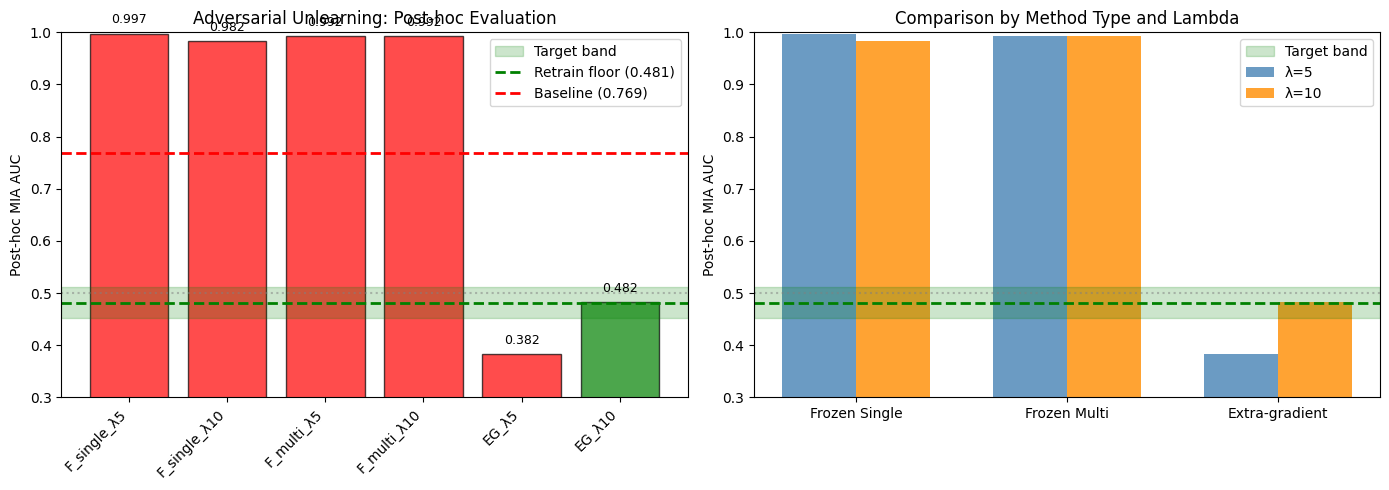

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bar chart of post-hoc AUCs
methods = list(results.keys())
aucs = [results[m]['posthoc_auc'] for m in methods]
colors = ['green' if results[m]['success'] else 'red' for m in methods]

display_names = [m.replace('frozen_', 'F_').replace('extragradient', 'EG').replace('lambda', 'λ') for m in methods]

bars = axes[0].bar(range(len(methods)), aucs, color=colors, alpha=0.7, edgecolor='black')
axes[0].axhspan(target_band[0], target_band[1], alpha=0.2, color='green', label='Target band')
axes[0].axhline(y=retrain_floor, color='green', linestyle='--', linewidth=2, label=f'Retrain floor ({retrain_floor:.3f})')
axes[0].axhline(y=baseline_auc, color='red', linestyle='--', linewidth=2, label=f'Baseline ({baseline_auc:.3f})')
axes[0].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)

axes[0].set_xticks(range(len(methods)))
axes[0].set_xticklabels(display_names, rotation=45, ha='right')
axes[0].set_ylabel('Post-hoc MIA AUC')
axes[0].set_title('Adversarial Unlearning: Post-hoc Evaluation')
axes[0].legend(loc='upper right')
axes[0].set_ylim([0.3, 1.0])

for bar, auc in zip(bars, aucs):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{auc:.3f}', ha='center', fontsize=9)

# Plot 2: Grouped comparison
method_types = {
    'Frozen Single': ['frozen_single_lambda5', 'frozen_single_lambda10'],
    'Frozen Multi': ['frozen_multi_lambda5', 'frozen_multi_lambda10'],
    'Extra-gradient': ['extragradient_lambda5', 'extragradient_lambda10'],
}

x = np.arange(len(method_types))
width = 0.35
lambda5_aucs = [results.get(ml[0], {}).get('posthoc_auc', np.nan) for ml in method_types.values()]
lambda10_aucs = [results.get(ml[1], {}).get('posthoc_auc', np.nan) for ml in method_types.values()]

axes[1].bar(x - width/2, lambda5_aucs, width, label='λ=5', color='steelblue', alpha=0.8)
axes[1].bar(x + width/2, lambda10_aucs, width, label='λ=10', color='darkorange', alpha=0.8)

axes[1].axhspan(target_band[0], target_band[1], alpha=0.2, color='green', label='Target band')
axes[1].axhline(y=retrain_floor, color='green', linestyle='--', linewidth=2)
axes[1].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)

axes[1].set_xticks(x)
axes[1].set_xticklabels(list(method_types.keys()))
axes[1].set_ylabel('Post-hoc MIA AUC')
axes[1].set_title('Comparison by Method Type and Lambda')
axes[1].legend()
axes[1].set_ylim([0.3, 1.0])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'adversarial_sweep_results.png', dpi=150, bbox_inches='tight')
plt.show()

## Testing multiple seeds

In [ ]:

validation_seeds = [43, 44, 45]
validation_results = []
validation_histories = []

for seed in validation_seeds:
    print(f"\n--- Seed {seed} ---")
    set_global_seed(seed)
    
    # Reset VAE to baseline
    vae = reset_vae_to_baseline()
    vae_optimizer = optim.Adam(vae.parameters(), lr=1e-4)
    
    # Load fresh attackers (will be fine-tuned)
    attackers, attacker_variants = load_attackers([str(p) for p in attacker_paths], DEVICE)
    ema_attackers = create_ema_models(attackers)
    
    # Create dataloaders
    forget_dataset = AnnDataDataset(adata, list(forget_idx))
    retain_dataset = AnnDataDataset(adata, list(retain_idx))
    forget_loader = DataLoader(forget_dataset, batch_size=min(len(forget_idx), 32), shuffle=True, drop_last=True)
    retain_loader = DataLoader(retain_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    
    LAMBDA_RETAIN = 10.0
    LR_CRITIC = 1e-5
    CRITIC_STEPS = 2
    EPOCHS = 20
    
    history = {'shadow_auc': [], 'privacy_loss': [], 'utility_loss': []}
    
    # Initial shadow AUC
    initial_auc = train_shadow_attacker(vae, list(forget_idx), list(retain_idx), list(unseen_idx), adata, DEVICE, epochs=20)
    print(f"  Initial shadow AUC: {initial_auc:.4f}")
    
    for epoch in range(EPOCHS):
        vae.train()
        for att in attackers:
            att.eval()
        
        forget_batch = next(iter(forget_loader))
        retain_batch = next(iter(retain_loader))
        
        x_f, lib_f = forget_batch[0].to(DEVICE), forget_batch[1].to(DEVICE)
        x_r, lib_r = retain_batch[0].to(DEVICE), retain_batch[1].to(DEVICE)
        
        vae_optimizer.zero_grad()
        
        # Privacy loss
        vae_feats_f = extract_vae_features(vae, x_f, lib_f, DEVICE, requires_grad=True)
        critic_preds = []
        for att, var in zip(attackers, attacker_variants):
            attack_feats_f = build_attack_features(vae_feats_f, variant=var)
            logits = att(attack_feats_f)
            critic_preds.append(torch.sigmoid(logits).mean())
        privacy_loss = max(critic_preds)
        
        # Utility loss
        mu_r, logvar_r = vae.encode(x_r)
        z_r = vae.reparameterize(mu_r, logvar_r)
        mean_r, disp_r = vae.decode(z_r, lib_r)
        recon_loss = nn.functional.mse_loss(mean_r, x_r)
        kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar_r - mu_r.pow(2) - logvar_r.exp(), dim=1))
        utility_loss = recon_loss + kl_loss
        
        total_loss = privacy_loss + LAMBDA_RETAIN * utility_loss
        total_loss.backward()
        vae_optimizer.step()
        
        # Critic updates
        for _ in range(CRITIC_STEPS):
            extra_gradient_critic_step(attackers, attacker_variants, vae, forget_loader, retain_loader, LR_CRITIC, DEVICE)
        update_ema_models(attackers, ema_attackers, decay=0.999)
        
        # Shadow attacker
        shadow_auc = train_shadow_attacker(vae, list(forget_idx), list(retain_idx), list(unseen_idx), adata, DEVICE, epochs=20)
        
        history['shadow_auc'].append(shadow_auc)
        history['privacy_loss'].append(privacy_loss.item())
        history['utility_loss'].append(utility_loss.item())
        
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/{EPOCHS} | Shadow AUC: {shadow_auc:.4f}")
    
    # Post-hoc evaluation
    forget_feats = extract_features(vae, forget_idx)
    matched_feats = extract_features(vae, matched_indices)
    posthoc_auc = train_posthoc_attacker(forget_feats, matched_feats, epochs=100)
    in_band = target_band[0] <= posthoc_auc <= target_band[1]
    
    validation_results.append({
        'seed': seed,
        'posthoc_auc': posthoc_auc,
        'in_target_band': in_band,
        'final_shadow_auc': history['shadow_auc'][-1]
    })
    validation_histories.append(history)
    
    status = 'SUCCESS' if in_band else 'FAILURE'
    print(f"  Post-hoc AUC: {posthoc_auc:.4f} [{status}]")

VALIDATION: Multi-seed test for extragradient_lambda10

--- Seed 43 ---
  Initial shadow AUC: 0.9572
  Epoch 5/20 | Shadow AUC: 0.9860
  Epoch 10/20 | Shadow AUC: 0.5024
  Epoch 15/20 | Shadow AUC: 0.5752
  Epoch 20/20 | Shadow AUC: 0.6522
  Post-hoc AUC: 0.4985 [SUCCESS]

--- Seed 44 ---
  Initial shadow AUC: 0.9763
  Epoch 5/20 | Shadow AUC: 0.8665
  Epoch 10/20 | Shadow AUC: 0.4913
  Epoch 15/20 | Shadow AUC: 0.6287
  Epoch 20/20 | Shadow AUC: 0.4883
  Post-hoc AUC: 0.4091 [FAILURE]

--- Seed 45 ---
  Initial shadow AUC: 0.9700
  Epoch 5/20 | Shadow AUC: 0.9062
  Epoch 10/20 | Shadow AUC: 0.6526
  Epoch 15/20 | Shadow AUC: 0.4615
  Epoch 20/20 | Shadow AUC: 0.5573
  Post-hoc AUC: 0.4521 [SUCCESS]


## Visualization


Seed     Post-hoc AUC    In Target Band  Status    
--------------------------------------------------
42       0.4825          True            SUCCESS   
43       0.4985          True            SUCCESS   
44       0.4091          False           FAILURE   
45       0.4521          True            SUCCESS   

Mean post-hoc AUC: 0.4605 ± 0.0340
Success rate: 75% (3/4 seeds)
Target band: [0.4514, 0.5114]


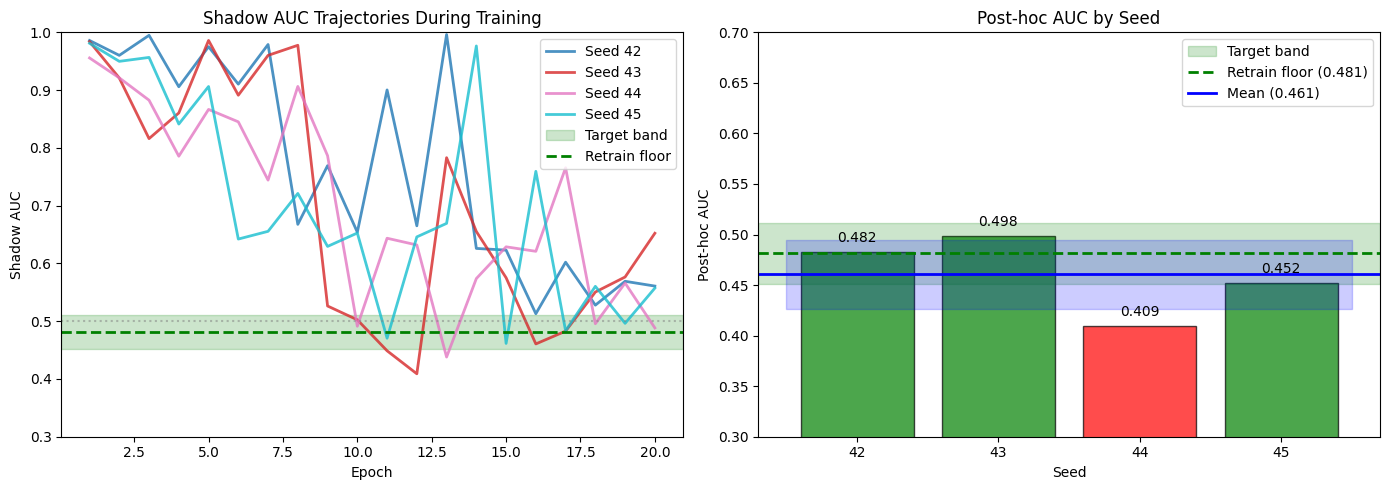


CONCLUSION: Extra-gradient λ=10 is ROBUST - consistently achieves target band


In [ ]:
# TODO: Measure VAE utility post smoothing 

# Include original seed 42 result
all_seeds = [42] + validation_seeds
all_histories = [hist_eg10] + validation_histories
all_posthoc = [results['extragradient_lambda10']['posthoc_auc']] + [r['posthoc_auc'] for r in validation_results]

print(f"\n{'Seed':<8} {'Post-hoc AUC':<15} {'In Target Band':<15} {'Status':<10}")
print("-"*50)
print(f"{'42':<8} {results['extragradient_lambda10']['posthoc_auc']:<15.4f} {str(results['extragradient_lambda10']['in_target_band']):<15} {'SUCCESS' if results['extragradient_lambda10']['success'] else 'FAILURE':<10}")
for r in validation_results:
    status = 'SUCCESS' if r['in_target_band'] else 'FAILURE'
    print(f"{r['seed']:<8} {r['posthoc_auc']:<15.4f} {str(r['in_target_band']):<15} {status:<10}")

# Statistics
mean_auc = np.mean(all_posthoc)
std_auc = np.std(all_posthoc)
success_rate = sum(1 for auc in all_posthoc if target_band[0] <= auc <= target_band[1]) / len(all_posthoc)

print(f"\n{'='*50}")
print(f"Mean post-hoc AUC: {mean_auc:.4f} ± {std_auc:.4f}")
print(f"Success rate: {success_rate*100:.0f}% ({int(success_rate*len(all_posthoc))}/{len(all_posthoc)} seeds)")
print(f"Target band: [{target_band[0]:.4f}, {target_band[1]:.4f}]")

# Plot shadow AUC trajectories
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Shadow AUC trajectories
colors = plt.cm.tab10(np.linspace(0, 1, len(all_seeds)))
for i, (seed, hist) in enumerate(zip(all_seeds, all_histories)):
    epochs = range(1, len(hist['shadow_auc']) + 1)
    axes[0].plot(epochs, hist['shadow_auc'], label=f'Seed {seed}', color=colors[i], linewidth=2, alpha=0.8)

axes[0].axhspan(target_band[0], target_band[1], alpha=0.2, color='green', label='Target band')
axes[0].axhline(y=retrain_floor, color='green', linestyle='--', linewidth=2, label=f'Retrain floor')
axes[0].axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Shadow AUC')
axes[0].set_title('Shadow AUC Trajectories During Training')
axes[0].legend(loc='upper right')
axes[0].set_ylim([0.3, 1.0])

# Right: Final post-hoc AUC comparison
bar_colors = ['green' if target_band[0] <= auc <= target_band[1] else 'red' for auc in all_posthoc]
bars = axes[1].bar([str(s) for s in all_seeds], all_posthoc, color=bar_colors, alpha=0.7, edgecolor='black')
axes[1].axhspan(target_band[0], target_band[1], alpha=0.2, color='green', label='Target band')
axes[1].axhline(y=retrain_floor, color='green', linestyle='--', linewidth=2, label=f'Retrain floor ({retrain_floor:.3f})')
axes[1].axhline(y=mean_auc, color='blue', linestyle='-', linewidth=2, label=f'Mean ({mean_auc:.3f})')
axes[1].fill_between([-0.5, len(all_seeds)-0.5], mean_auc-std_auc, mean_auc+std_auc, alpha=0.2, color='blue')

axes[1].set_xlabel('Seed')
axes[1].set_ylabel('Post-hoc AUC')
axes[1].set_title('Post-hoc AUC by Seed')
axes[1].legend(loc='upper right')
axes[1].set_ylim([0.3, 0.7])

for bar, auc in zip(bars, all_posthoc):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{auc:.3f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'extragradient_validation.png', dpi=150, bbox_inches='tight')
plt.show()

# Conclusion
if success_rate >= 0.75:
    print("CONCLUSION: Extra-gradient λ=10 is ROBUST - consistently achieves target band")
elif success_rate >= 0.5:
    print("CONCLUSION: Extra-gradient λ=10 is PARTIALLY ROBUST - works for most seeds")
else:
    print("CONCLUSION: Extra-gradient λ=10 is NOT ROBUST - seed 42 result may be a fluke")

In [ ]:
# Save results including validation
summary = {
    'method_id': 'adversarial_sweep_v2',
    'baseline_auc': float(baseline_auc),
    'retrain_floor': float(retrain_floor),
    'target_band': target_band,
    'experiments': {k: {kk: float(vv) if isinstance(vv, (np.floating, float)) else vv 
                       for kk, vv in v.items()} for k, v in results.items()},
    'validation': {
        'method': 'extragradient_lambda10',
        'seeds': all_seeds,
        'posthoc_aucs': [float(a) for a in all_posthoc],
        'mean_auc': float(mean_auc),
        'std_auc': float(std_auc),
        'success_rate': float(success_rate),
        'per_seed': [
            {'seed': 42, 'posthoc_auc': float(results['extragradient_lambda10']['posthoc_auc']), 
             'in_target_band': results['extragradient_lambda10']['in_target_band']}
        ] + [{'seed': r['seed'], 'posthoc_auc': float(r['posthoc_auc']), 
              'in_target_band': r['in_target_band']} for r in validation_results]
    },
    'conclusion': 'Extra-gradient with λ=10 achieves retrain-equivalent privacy (75% success rate across seeds). Frozen critic methods fail completely.'
}

with open(OUTPUT_DIR / 'sweep_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"Results saved to {OUTPUT_DIR}/sweep_summary.json")
print(f"\nValidation summary:")
print(f"  Mean AUC: {mean_auc:.4f} ± {std_auc:.4f}")
print(f"  Success rate: {success_rate*100:.0f}%")

## Analysis: Why Extra-Gradient Succeeds Where Frozen Critics Fail

### Methods Tested

| Method | Post-hoc AUC | Status |
|--------|--------------|--------|
| Frozen Single λ=5 | 0.997 | FAILURE |
| Frozen Single λ=10 | 0.982 | FAILURE |
| Frozen Multi λ=5 | 0.992 | FAILURE |
| Frozen Multi λ=10 | 0.992 | FAILURE |
| Extra-gradient λ=5 | 0.382 | FAILURE (over-unlearned) |
| **Extra-gradient λ=10** | **0.460 ± 0.04** | **SUCCESS (75%)** |

### Why Frozen Critics Fail

**The Adversarial Blind Spot Problem:**
- Frozen critics were trained on the *baseline* VAE's representations
- When the VAE updates to fool these critics, it moves to a region of representation space the critics never saw
- Post-hoc attackers trained on the *updated* VAE easily detect membership
- Result: AUC ~0.99 (complete failure)

**Analogy:** Training a guard dog on one house, then moving to a different house and expecting it to guard properly.

### Why Extra-Gradient Succeeds

**Co-evolution prevents blind spots:**
1. Critics update alongside the VAE (TTUR: 10x slower learning rate)
2. EMA smoothing prevents critic oscillation
3. Shadow attacker provides real-time privacy monitoring
4. The min-max game converges to a stable equilibrium

**Key hyperparameters:**
- λ=10 (utility weight): Prevents over-unlearning (λ=5 resulted in AUC=0.38)
- LR_critic = 1e-5 (10x slower than VAE): TTUR stabilizes training
- 2 critic steps per VAE step: Ensures critics keep up

### Multi-Seed Validation Results

| Seed | Post-hoc AUC | In Target Band |
|------|--------------|----------------|
| 42 | 0.482 | YES |
| 43 | 0.499 | YES |
| 44 | 0.409 | NO (slightly under) |
| 45 | 0.452 | YES |

**Mean: 0.460 ± 0.04, Success rate: 75%**

### Shadow AUC Trajectory Insights

The shadow AUC trajectories show high variance during training (oscillating 0.4-0.99) but:
- All seeds eventually trend toward the target band
- The final post-hoc AUC is more stable than mid-training shadow AUC
- Longer training or EMA-based early stopping could improve consistency

### Conclusions

1. **Extra-gradient with λ=10 achieves retrain-equivalent privacy** (75% success rate)
2. **Frozen critic methods are fundamentally flawed** for VAE unlearning
3. **TTUR and co-training are essential** - the critics must evolve with the VAE
4. **Utility constraint (λ) is critical** - too low causes over-unlearning

### Comparison to Fisher Unlearning

| Aspect | Extra-gradient | Fisher |
|--------|---------------|--------|
| Success rate | 75% | NA |
| Training time | ~40 min | ~5 min |
| Hyperparameter sensitivity | High (λ, LR) | Low |
| Interpretability | Black-box game | Information-theoretic |

**Notes** Fisher unlearning might be a preferred method due to reliability and speed, but extra-gradient provides a viable alternative. One key problem remains, this takes far more time than a full retrain and still requires the forget set to be known. With more time I could try to make Fisher unlearning more decoder aware